# **Importing Dependencies**

In [1]:
!pip install ultralytics -q
%env WANDB_DISABLED=True

env: WANDB_DISABLED=True


In [2]:
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import shutil
from PIL import Image
import os
from sklearn.model_selection import train_test_split

# **Data Preprocessing**

In [3]:
#Defining Directories
BASE_DIR = r"/kaggle/input/kitti-dataset"
IMAGE_DIR = r"/kaggle/input/kitti-dataset/data_object_image_2/training/image_2"
LABEL_DIR = r"/kaggle/input/kitti-dataset-yolo-format/labels"

In [4]:
classes = {'Car': 0,    ## Class with thier corresponding label
 'Pedestrian': 1,
 'Van': 2,
 'Cyclist': 3,
 'Truck': 4,
 'Misc': 5,
 'Tram': 6,
 'Person_sitting': 7}

In [5]:
'''Looping through the Image and Label Base directories and appending the file names in a
    list according to alphabetical order'''

images = sorted([img for img in os.listdir(IMAGE_DIR)])            
labels = sorted([label for label in os.listdir(LABEL_DIR)])                


pair = list(zip(images,labels))  # Zipping a Image with its corresponding label file
pair[:3]  # Outputting a few zipped Image-Label pairs

[('000000.png', '000000.txt'),
 ('000001.png', '000001.txt'),
 ('000002.png', '000002.txt')]

In [6]:
train, test = train_test_split(pair,test_size=0.1,shuffle=True)  # Doing a 90%-10% : Train-Test split 
len(train), len(test)

(6732, 749)

In [7]:
def create_separate_dirs(dir_name):
    try:
        os.mkdir(dir_name)
    except FileExistsError:
        pass

In [8]:
specific_dirs = ['train_path','train_path/images','train_path/labels',
                  'valid_path','valid_path/images', 'valid_path/labels']

for f in specific_dirs:
    create_separate_dirs(f)

In [9]:
try:
    os.mkdir('valid_path/labels')
except FileExistsError:
    pass

In [10]:
for image_path,label_path in tqdm(train):  #Copying Training Images and Labels from Base directories to training directories
    shutil.copy(os.path.join(IMAGE_DIR,image_path),os.path.join('train_path/images',image_path))
    shutil.copy(os.path.join(LABEL_DIR,label_path),os.path.join('train_path/labels',label_path))

  0%|          | 0/6732 [00:00<?, ?it/s]

In [11]:
for image_path,label_path in tqdm(test):    #Copying Validation Images and Labels from Base directories to validation directories
    shutil.copy(os.path.join(IMAGE_DIR,image_path),os.path.join('valid_path/images',image_path))
    shutil.copy(os.path.join(LABEL_DIR,label_path),os.path.join('valid_path/labels',label_path))

  0%|          | 0/749 [00:00<?, ?it/s]

## Preparing YAML file structure

The official Ultralytics Datasets structure states that - " Arrange your dataset into the correct folder structure. You should have train/ and val/ top-level directories, and within each, an images/ and labels/ subdirectory"

### Example Structure
dataset/ <br>
├── train/ <br>
│   ├── images/ <br>
│   └── labels/ <br>
└── val/ <br>
    ├── images/ <br>
    └── labels/ <br>

In [16]:
train_write = '/kaggle/working/train_path/images'
valid_write = '/kaggle/working/valid_path/images'
yaml_file = 'names:\n'
yaml_file += '\n'.join(f'- {c}' for c in classes)
yaml_file += f'\nnc: {len(classes)}'
yaml_file += f'\ntrain: {train_write}\nval: {valid_write}'
with open('data.yaml','w') as f:
    f.write(yaml_file)

In [13]:
!cat data.yaml

names:
- Car
- Pedestrian
- Van
- Cyclist
- Truck
- Misc
- Tram
- Person_sitting
nc: 8
train: /kaggle/working/train_path/images
val: /kaggle/working/valid_path/images

# Training the Model

In [14]:
model = YOLO('yolov8n.yaml')
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 111MB/s]


In [15]:
train_results = model.train(
    data='/kaggle/working/data.yaml', 
    epochs=45,
    patience=10,
    mixup=0.15,
    device = 0
)

Ultralytics YOLOv8.1.42 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=45, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

100%|██████████| 755k/755k [00:00<00:00, 19.4MB/s]
2024-04-04 18:48:34,080	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-04-04 18:48:34,984	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-04-04 18:48:37.551129: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 18:48:37.551240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 18:48:37.688701: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS facto

Overriding model.yaml nc=80 with nc=8

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/train_path/labels... 6732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6732/6732 [00:40<00:00, 165.15it/s]


train: New cache created: /kaggle/working/train_path/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/valid_path/labels... 749 images, 0 backgrounds, 0 corrupt: 100%|██████████| 749/749 [00:03<00:00, 207.66it/s]

val: New cache created: /kaggle/working/valid_path/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 45 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/45      2.48G       1.43      1.776      1.119        192        640: 100%|██████████| 421/421 [01:49<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.76it/s]


                   all        749       4225      0.599      0.332      0.356       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/45       2.4G      1.298        1.2       1.08        119        640: 100%|██████████| 421/421 [01:41<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.36it/s]


                   all        749       4225      0.592      0.411      0.455      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/45      2.47G      1.259      1.065      1.071        158        640: 100%|██████████| 421/421 [01:41<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.03it/s]


                   all        749       4225      0.535      0.516      0.525      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/45      2.48G      1.235     0.9965      1.061        131        640: 100%|██████████| 421/421 [01:41<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.50it/s]


                   all        749       4225      0.687      0.529      0.587      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/45      2.39G      1.207     0.9433      1.056        130        640: 100%|██████████| 421/421 [01:41<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.33it/s]

                   all        749       4225       0.74      0.493      0.602      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/45      2.45G      1.175     0.8958      1.038        109        640: 100%|██████████| 421/421 [01:41<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.74it/s]


                   all        749       4225      0.693      0.504      0.604      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/45      2.46G      1.155      0.865      1.033        212        640: 100%|██████████| 421/421 [01:41<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.44it/s]


                   all        749       4225      0.709      0.598      0.676      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/45      2.46G      1.137     0.8427      1.026        143        640: 100%|██████████| 421/421 [01:42<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.47it/s]

                   all        749       4225      0.751      0.562      0.669      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/45      2.48G      1.122     0.8162       1.02        156        640: 100%|██████████| 421/421 [01:42<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.35it/s]


                   all        749       4225      0.702       0.63      0.696      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/45      2.46G       1.11     0.8072      1.019        171        640: 100%|██████████| 421/421 [01:42<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.54it/s]


                   all        749       4225      0.648      0.666      0.707      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/45      2.57G        1.1     0.7896       1.01        127        640: 100%|██████████| 421/421 [01:42<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.19it/s]


                   all        749       4225      0.707      0.675      0.723      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/45      2.45G       1.09     0.7784       1.01        152        640: 100%|██████████| 421/421 [01:42<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.48it/s]


                   all        749       4225      0.782      0.653      0.754      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/45      2.47G      1.068     0.7569     0.9993        187        640: 100%|██████████| 421/421 [01:41<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.10it/s]


                   all        749       4225      0.831      0.628      0.738      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/45      2.46G      1.064     0.7458     0.9996        121        640: 100%|██████████| 421/421 [01:43<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.34it/s]

                   all        749       4225      0.819      0.664      0.758        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/45      2.39G      1.055     0.7367     0.9946        160        640: 100%|██████████| 421/421 [01:42<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.15it/s]

                   all        749       4225      0.783      0.678       0.74      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/45      2.46G      1.043     0.7227     0.9901        173        640: 100%|██████████| 421/421 [01:41<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.17it/s]

                   all        749       4225      0.829      0.695       0.78      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/45      2.46G      1.036     0.7189     0.9887        163        640: 100%|██████████| 421/421 [01:41<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.45it/s]


                   all        749       4225      0.798      0.665       0.75      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/45      2.46G      1.036     0.7153     0.9858        172        640: 100%|██████████| 421/421 [01:41<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.40it/s]

                   all        749       4225      0.872      0.655      0.772      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/45      2.49G       1.02     0.7013      0.984        165        640: 100%|██████████| 421/421 [01:41<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.30it/s]

                   all        749       4225      0.801      0.717      0.792      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/45      2.45G      1.012     0.6926     0.9786        141        640: 100%|██████████| 421/421 [01:41<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.33it/s]

                   all        749       4225      0.805      0.714      0.789      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/45      2.45G      1.009     0.6895     0.9757        148        640: 100%|██████████| 421/421 [01:41<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.20it/s]


                   all        749       4225      0.871      0.723      0.815      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/45      2.46G      1.004     0.6801     0.9748        141        640: 100%|██████████| 421/421 [01:42<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.22it/s]

                   all        749       4225      0.874      0.713      0.806       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/45      2.45G     0.9914     0.6744     0.9718        127        640: 100%|██████████| 421/421 [01:42<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.39it/s]


                   all        749       4225      0.913      0.707      0.815      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/45      2.46G     0.9883     0.6692     0.9701        183        640: 100%|██████████| 421/421 [01:43<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.30it/s]


                   all        749       4225      0.884       0.71      0.822      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/45      2.46G     0.9726     0.6545     0.9641         98        640: 100%|██████████| 421/421 [01:41<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.38it/s]


                   all        749       4225      0.839      0.737      0.822       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/45      2.62G     0.9743     0.6575     0.9663        104        640: 100%|██████████| 421/421 [01:42<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.86it/s]

                   all        749       4225      0.835      0.745      0.826      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/45      2.44G     0.9656     0.6473     0.9641        189        640: 100%|██████████| 421/421 [01:41<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.47it/s]


                   all        749       4225      0.812      0.762      0.822      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/45      2.46G     0.9565     0.6407     0.9589         92        640: 100%|██████████| 421/421 [01:42<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.22it/s]

                   all        749       4225       0.86      0.735      0.825      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/45      2.39G     0.9579     0.6361     0.9598        165        640: 100%|██████████| 421/421 [01:41<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.15it/s]


                   all        749       4225       0.85      0.755      0.828      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/45      2.44G     0.9399      0.624      0.952        132        640: 100%|██████████| 421/421 [01:41<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.22it/s]


                   all        749       4225      0.836      0.743      0.833      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/45      2.44G      0.938     0.6223     0.9509        162        640: 100%|██████████| 421/421 [01:41<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.34it/s]

                   all        749       4225      0.882      0.761      0.848      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/45      2.46G     0.9405     0.6222     0.9518        145        640: 100%|██████████| 421/421 [01:41<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.51it/s]


                   all        749       4225      0.867      0.778      0.855      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/45      2.44G     0.9277     0.6127     0.9485        138        640: 100%|██████████| 421/421 [01:41<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.54it/s]

                   all        749       4225      0.904      0.747      0.854      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/45      2.45G     0.9202     0.6051     0.9461         92        640: 100%|██████████| 421/421 [01:39<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.35it/s]

                   all        749       4225      0.892      0.754      0.852      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/45      2.39G     0.9144     0.6036     0.9464        185        640: 100%|██████████| 421/421 [01:39<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.52it/s]

                   all        749       4225      0.898      0.746      0.855      0.604


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/45      2.39G     0.8407     0.5227     0.9141         52        640: 100%|██████████| 421/421 [01:29<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.94it/s]

                   all        749       4225      0.886      0.754      0.853      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/45      2.39G     0.8234     0.5097     0.9057         88        640: 100%|██████████| 421/421 [01:27<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.01it/s]


                   all        749       4225      0.859      0.794      0.865      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/45      2.39G     0.8124     0.5019     0.9044         67        640: 100%|██████████| 421/421 [01:26<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.51it/s]

                   all        749       4225      0.886      0.785      0.861      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/45      2.39G     0.8044     0.4959      0.902         44        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.57it/s]


                   all        749       4225      0.905      0.751      0.864      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/45      2.39G     0.7984     0.4901     0.8996         50        640: 100%|██████████| 421/421 [01:26<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.90it/s]

                   all        749       4225      0.871      0.797      0.872       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/45      2.39G     0.7886      0.482     0.8969         55        640: 100%|██████████| 421/421 [01:26<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.88it/s]

                   all        749       4225      0.918      0.781      0.875       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/45      2.39G      0.782     0.4822     0.8935         76        640: 100%|██████████| 421/421 [01:26<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.64it/s]

                   all        749       4225      0.886      0.792      0.881      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/45      2.39G     0.7768     0.4761     0.8911         49        640: 100%|██████████| 421/421 [01:26<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.78it/s]


                   all        749       4225      0.911      0.782      0.884      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/45      2.39G      0.768     0.4714     0.8885         61        640: 100%|██████████| 421/421 [01:26<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.84it/s]


                   all        749       4225      0.902      0.792      0.881      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/45      2.39G     0.7627     0.4663     0.8871         76        640: 100%|██████████| 421/421 [01:26<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.86it/s]

                   all        749       4225      0.914      0.787      0.879      0.635



45 epochs completed in 1.314 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.42 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 3007208 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.67it/s]


                   all        749       4225      0.902      0.793      0.881      0.639
                   Car        749       3011      0.912      0.883      0.944      0.749
            Pedestrian        749        520      0.885      0.649      0.793      0.446
                   Van        749        289      0.903      0.869      0.935      0.749
               Cyclist        749        163      0.924      0.751      0.847      0.548
                 Truck        749         94      0.953      0.926      0.952      0.791
                  Misc        749         83      0.901      0.735      0.837       0.59
                  Tram        749         51      0.883      0.961      0.978      0.734
        Person_sitting        749         14      0.857      0.571      0.763      0.508
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train


# Assessing Model Performance

In [17]:
results = model.val()   # Looking at model's performance on the validation set 

Ultralytics YOLOv8.1.42 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 3007208 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/valid_path/labels.cache... 749 images, 0 backgrounds, 0 corrupt: 100%|██████████| 749/749 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.38it/s]


                   all        749       4225      0.905      0.794      0.882       0.64
                   Car        749       3011      0.913      0.883      0.944       0.75
            Pedestrian        749        520      0.897      0.656      0.798      0.445
                   Van        749        289      0.903      0.869      0.935       0.75
               Cyclist        749        163      0.924      0.751      0.847      0.544
                 Truck        749         94      0.952      0.926      0.952      0.795
                  Misc        749         83        0.9      0.735      0.838      0.593
                  Tram        749         51      0.897      0.961      0.979      0.738
        Person_sitting        749         14      0.855      0.571      0.761      0.508
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train2


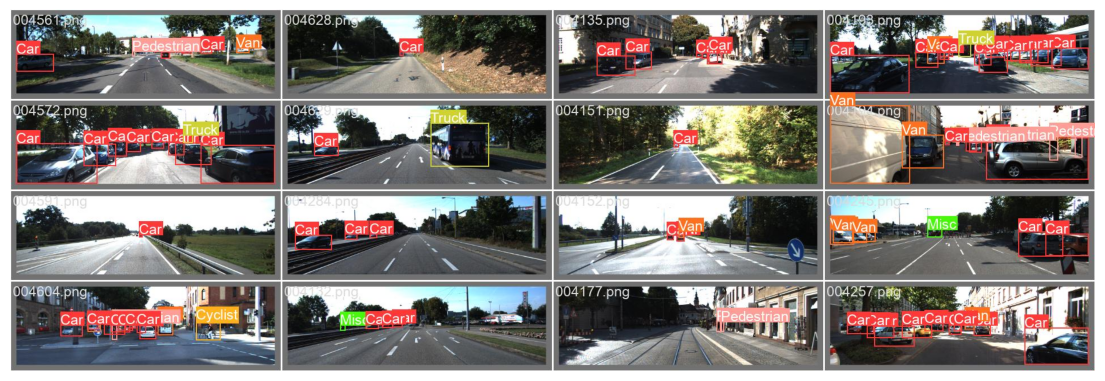

In [18]:
plt.figure(figsize=(14,20))
plt.imshow(Image.open('/kaggle/working/runs/detect/train2/val_batch1_labels.jpg')) # Visualization Validation Set predictions
plt.axis('off')
plt.show()

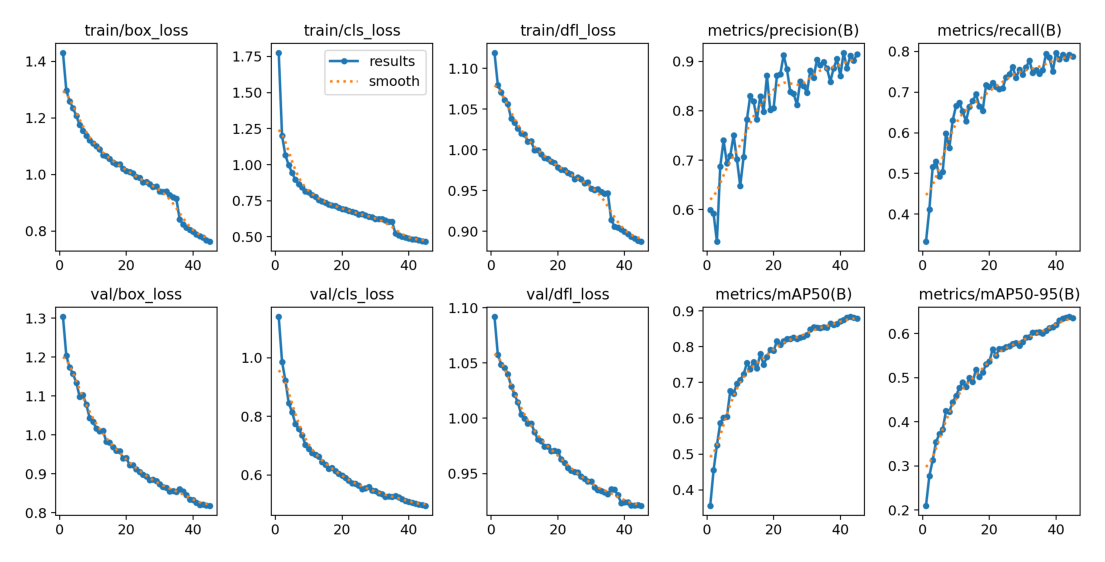

In [19]:
plt.figure(figsize=(14,20))
plt.imshow(Image.open('/kaggle/working/runs/detect/train/results.png'))  # Visualizing Training Performance Metrics
plt.axis('off')
plt.show()

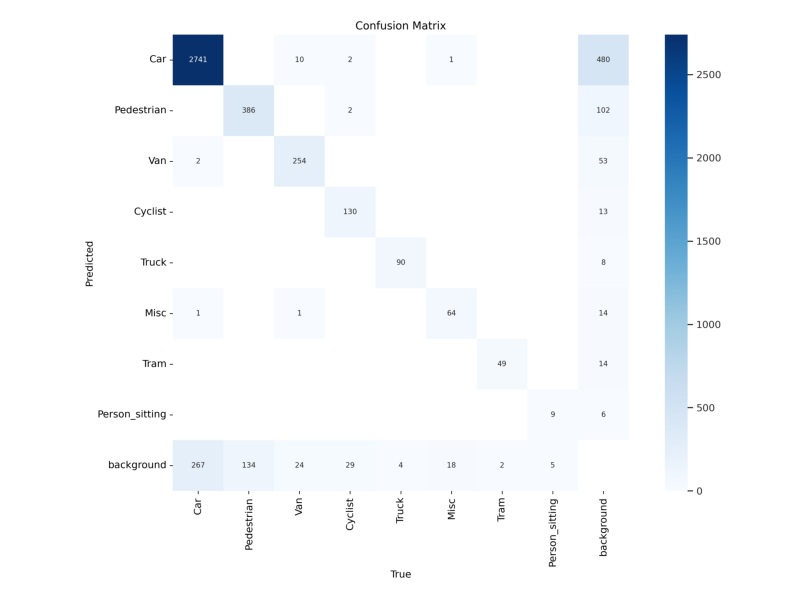

In [20]:
plt.figure(figsize=(10,20))
plt.imshow(Image.open('/kaggle/working/runs/detect/train/confusion_matrix.png'))  # Visualizing Confusion Matrix
plt.axis('off')
plt.show()


# Running Predictions on any random five Images from the validation set (Unseen Data)

In [21]:
preds = model.predict([os.path.join(valid_write,test[np.random.randint(0,len(test)-1)][0]) for _ in range(5)],save=True)


0: 224x640 4 Cars, 1 Misc, 14.5ms
1: 224x640 1 Car, 1 Pedestrian, 3 Trams, 14.5ms
2: 224x640 2 Cars, 3 Cyclists, 1 Misc, 14.5ms
3: 224x640 13 Cars, 14.5ms
4: 224x640 6 Cars, 1 Van, 14.5ms
Speed: 1.2ms preprocess, 14.5ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 640)
Results saved to runs/detect/train3


In [22]:
preds = list(Path('runs/detect/train3').glob('*'))

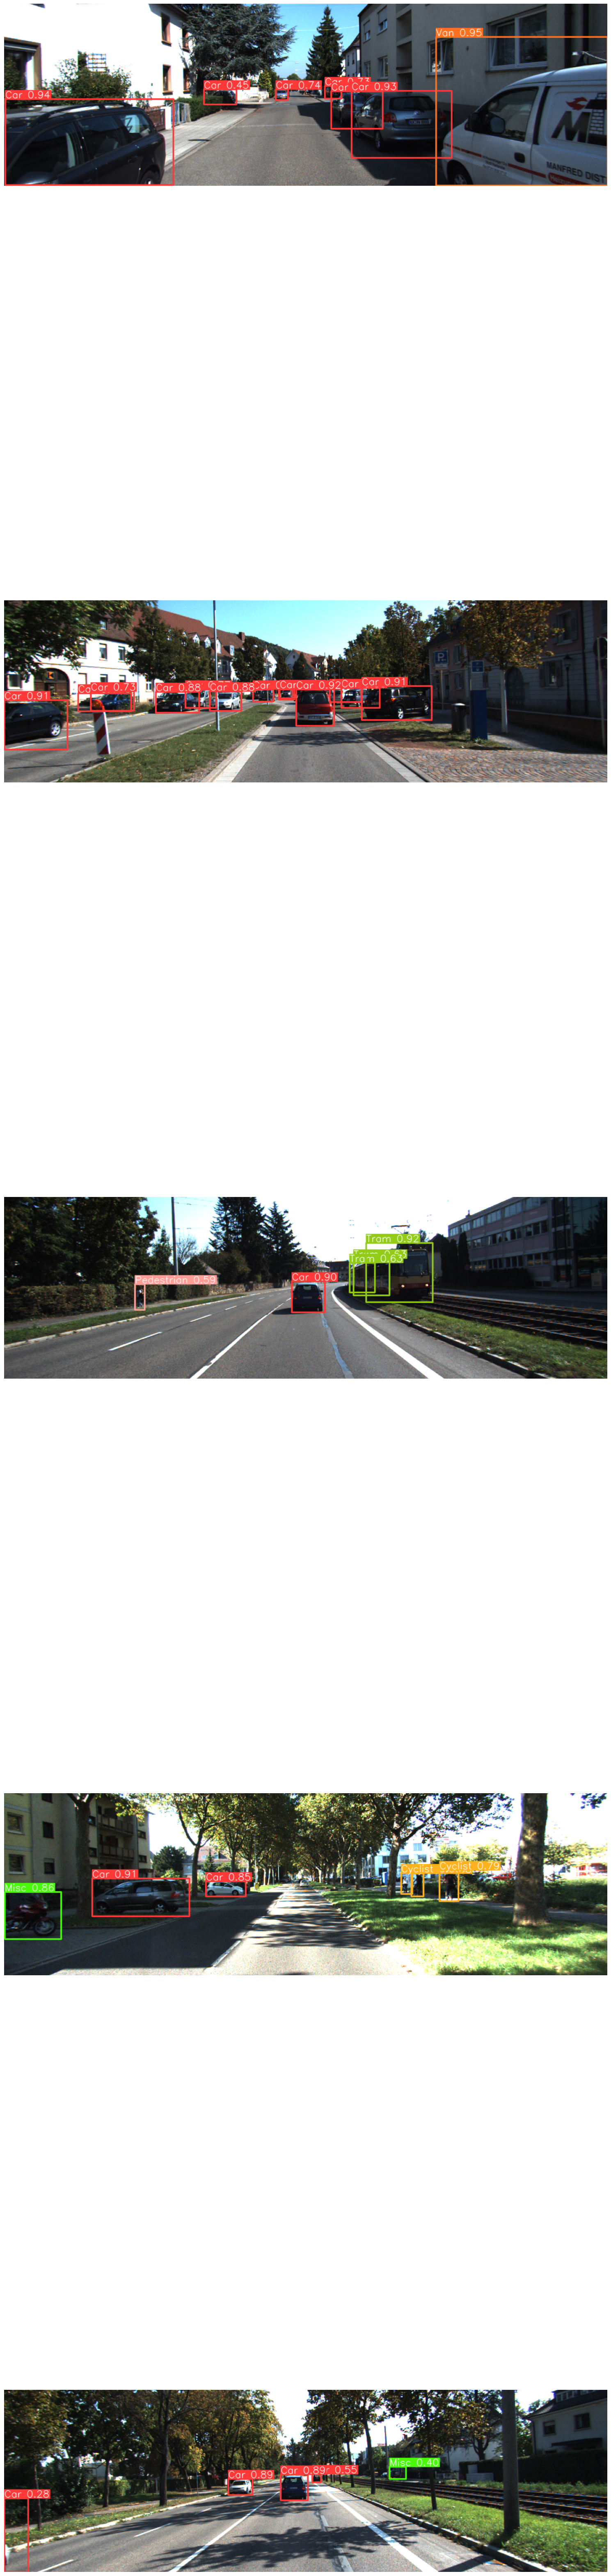

In [23]:
def plot_images(images):
    num_images = len(images)
    rows = num_images
    cols = 1
    fig, axes = plt.subplots(rows, cols, figsize=(15, 80))
    for ax in axes.flat:
        ax.axis('off')
    for i, img_path in enumerate(images):
        img = Image.open(img_path)
        axes[i].imshow(img)
    
    plt.tight_layout()
    plt.show()
    
plot_images(preds)

# Downloading the Weights of the Trained Model

In [24]:
!zip -r results.zip /kaggle/working/runs/detect/train

  adding: kaggle/working/runs/detect/train/ (stored 0%)
  adding: kaggle/working/runs/detect/train/val_batch1_pred.jpg (deflated 10%)
  adding: kaggle/working/runs/detect/train/results.csv (deflated 84%)
  adding: kaggle/working/runs/detect/train/results.png (deflated 8%)
  adding: kaggle/working/runs/detect/train/train_batch14736.jpg (deflated 18%)
  adding: kaggle/working/runs/detect/train/events.out.tfevents.1712256526.c01c26c83578.34.0 (deflated 90%)
  adding: kaggle/working/runs/detect/train/train_batch14737.jpg (deflated 21%)
  adding: kaggle/working/runs/detect/train/val_batch0_pred.jpg (deflated 9%)
  adding: kaggle/working/runs/detect/train/train_batch14735.jpg (deflated 22%)
  adding: kaggle/working/runs/detect/train/R_curve.png (deflated 6%)
  adding: kaggle/working/runs/detect/train/weights/ (stored 0%)
  adding: kaggle/working/runs/detect/train/weights/best.pt (deflated 9%)
  adding: kaggle/working/runs/detect/train/weights/last.pt (deflated 9%)
  adding: kaggle/working/ru

In [25]:
from IPython.display import FileLink

# Create a link to the file
FileLink(r'results.zip')

/kaggle/working/results.zip